# Exploring Ames Housing Data

## What this notebook shows

These are my notes from the following Kaggle kernel for hosue pricing predictions: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

The notes are specific to my own knowledge gaps. I need to get used to the initial data exploration phase. Working on this aspect of data science should help with choosing the correct set of models to experiement with. I'm going to try to have an exploration notebook for each project I work on.

### Setup
Seaborn is a pretty sweet statistical visualization library build on top of matplotlib

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
print("Done")

Done


### Explore

Now let's get to know the data. First, let's take a look at all the columns (i.e. features):

In [7]:
df_train = pd.read_csv('..//Data/train.csv')
print(df_train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

It's a bit exhausting, but it's a good idea to go through these features and read all their descriptions in the description file. I want to get an idea of what information is collected and what might be useful. When going through this, it's recommended to keep an Excel spreadsheet with a few categories such as data type, quality of feature, influence on final prediction, or anything else relevant to the specific scenario.

Getting to know a new dataset takes time, there's no getting around that. The good news is that once you've done the initial reading and exploration upfront, you're free to expirement as much as you want after that.

Let's take a look at the variable we are trying to predict, SalePrice:

In [8]:
print(df_train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


Distribution are super useful initially. We need to get an idea of the data's *skewness*. Remember from stats class:

**Skewness** is the degree of distortion from the normal distribution
* Positive skewness is when the tail is on the right
* Negative skewness is when the tail is on the left

* Low skewness is betweeen -0.5 and 0.5
* Medium is up to -1 and 1
* High is anything beyond -1 or 1

**Kurtosis** tells you about the outliers. It describes the tails and extremes.
* Mesokurtic is if the value of kurtosis = 3. This means it's close to a normal distribution
* Leptokurtic is if the value is > 3. This means there are more outliers, higher peaks, and longer/flatter tails
* Platykrtic is if the value is < 3. It means there are less outliers, lower peaks, and shorter/thiner tails

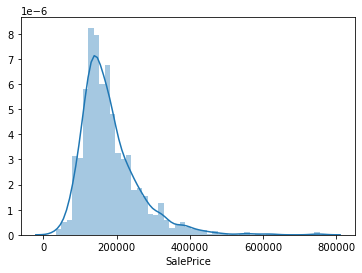

Skewness: 1.882876
Kurtosis: 6.536282


In [10]:
sns.distplot(df_train['SalePrice'])
plt.show()
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Let's compare SalePrice with some variables that caught our attention. Let's start with some numerical variables, like GrLivArea and TotalBsmtSF.

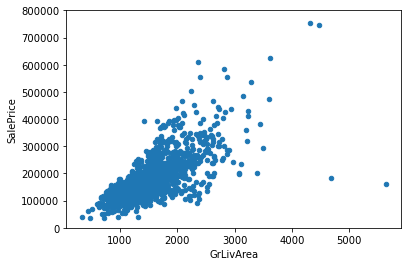

In [13]:
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

This relationship looks linear for the most part

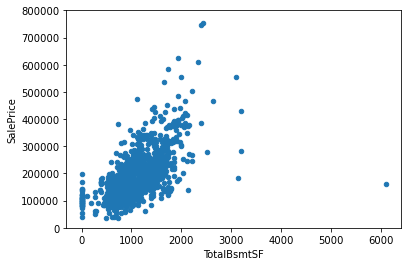

In [14]:
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

This one looks either linear with a super sharp slope, or even exponential. It kinda looks like it start linear at first, then all of a sudden goes exponential.

What about categorical features? OverallQual is an interesting one because it's a rating from 1 - 10. Since the values are discrete this is a categorical variable. We don't really know how these houses were assessed to get this number, so we can't be sure how relevant it will be on final results. A box plot would be helpful to get an idea.

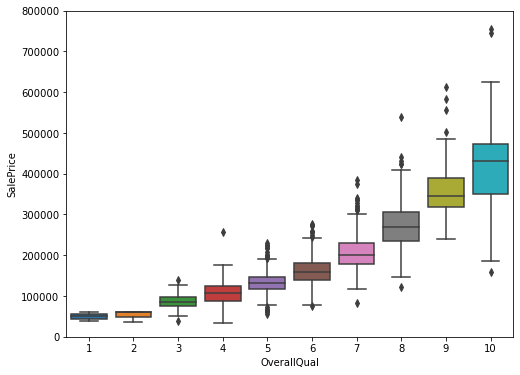

In [15]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

So it looks like OverallQual is very relevant to the SalePrice! This could be a good feature to include.

Let's do the same for YearBuilt.

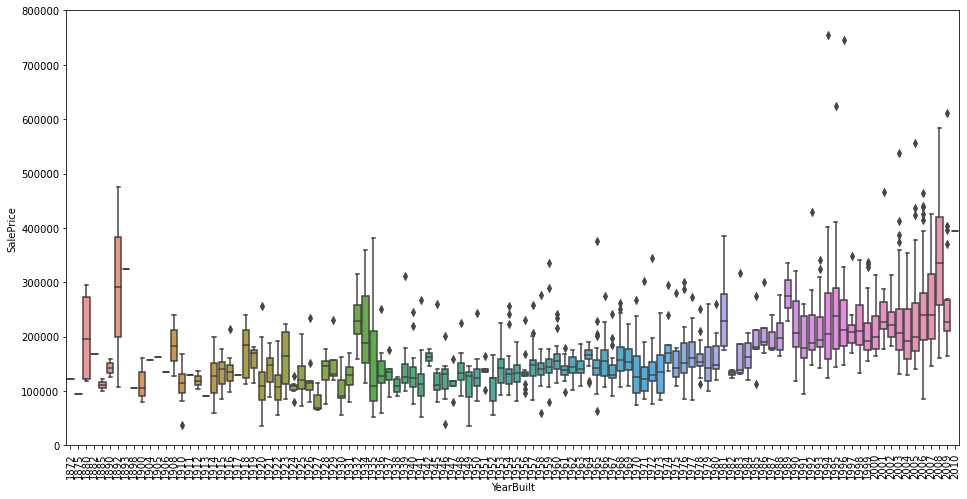

In [16]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

It's a pretty weak trend, but it does seem like in general the more expensive houses were built more recently.

For these first 4 charts we just followed our intuition with which variables are important. This can be fine initially, but we can't let our pre-conceived notions get in the way of our analysis. Let's get more objective

### Correlations

Let's take at correlation in a couple different styles: Correlation matrix and scatter plots

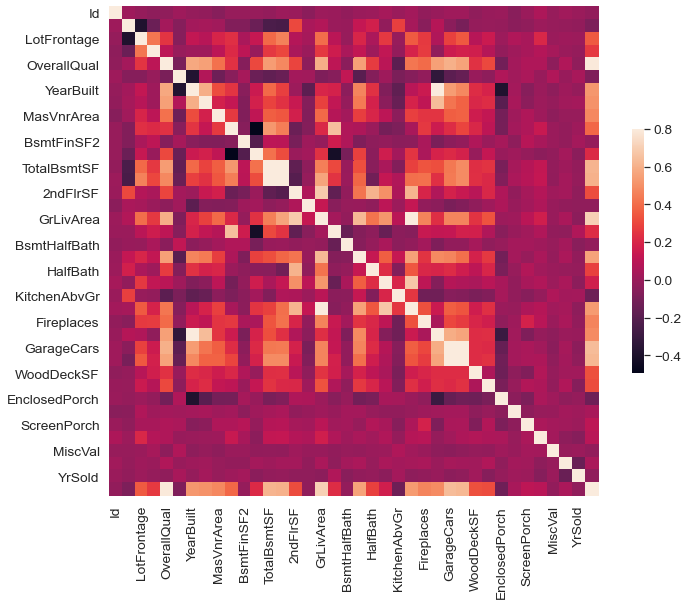

In [26]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Looks like lots of correlations! A couple notes on this heatmap:
* A max_val of 0.8 was used because it's the right balance of color shades. Increasing it to 1 makes for a lot of dark spaces that make it hard to pick out correlations. Lowering the max value makes the colors all super bright, which also makes it hard to differentiate.
* The ultra bright whitespots can be helpful for showing redundant variables. For example, YearBuilt and GarageYrBuilt. These are almost 100% correlation because a house and garage are almost always built at the same time.
* A better vissualization would probably be to only show half of this... Split diagonally, the two triangles are just mirrors of each other

Looking at just the SalePrice, we'd probably get a better idea of what's correlated if we zoom in on the K largest correlations.

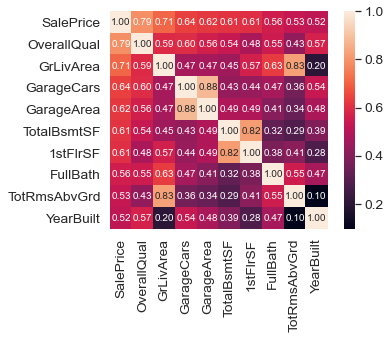

In [23]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Some notes that stickout:
* OverallQual and GrLivArea are both strongly correlated like we assumed. Cool
* GarageCars and GarageArea are brothers. We can just use 1 of these variables. We'll go with GarageCars since the correlation is stronger
* TotalBsmtSF and 1stFlrSF are also brothers, so just choose TotalBsmtSF
* FullBath also slightly correlated. May or may not wind up being useful in the end
* Year built is also slightly correlated. This is the kind of variable that would be better to do time-series analysis with though... that's for another day

Let's zoom even further on just the variables that are correlated. We can do a pretty cool pairplot using Seaborn for this.

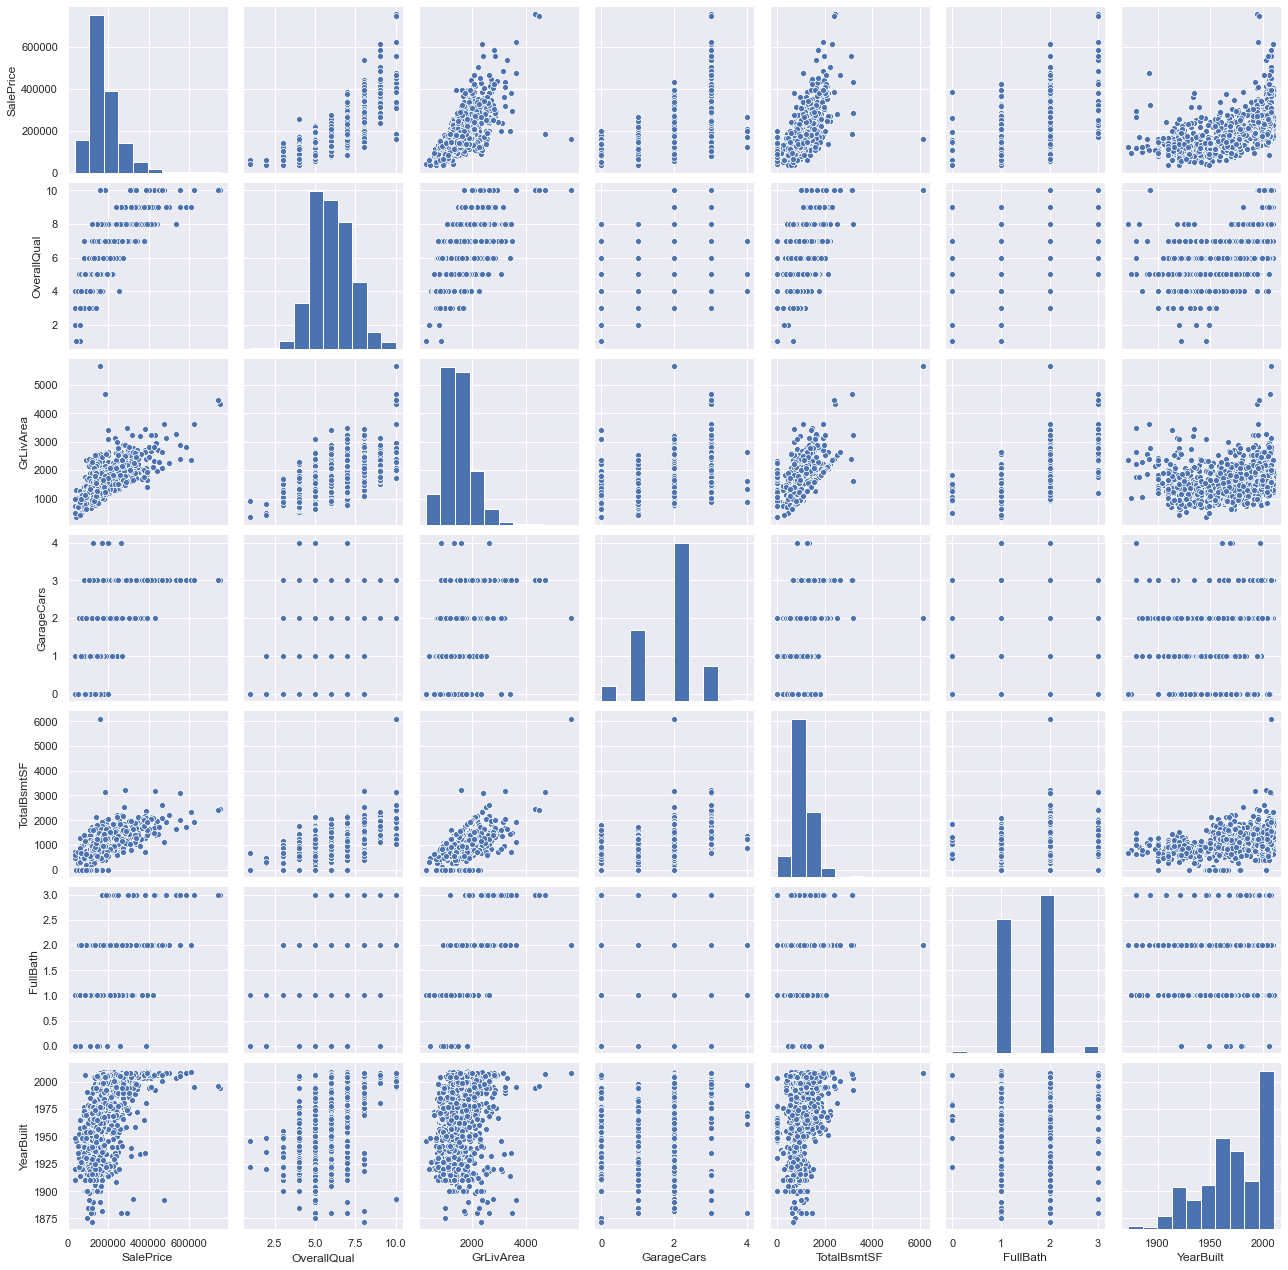

In [28]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)
plt.show();

We know some of this info already, but it's still a good visualization. A couple random notes. First is with totalBsmtSF and GrLivingArea. There's a stright line because unless you're buying a bunker, your basement area won't ever be larger than your house area. The other interesting plot is SalePrice and YearBuilt. It shows a slight exponential relationship

## Missing Values

2 primary questions to ask:
* How prevelant is missing data?
* Is missing data random or does it have a pattern?

This is important because missing data can imply a reduction in sample size, which can prevent us from preceeding with analysis. Additionally, if there is a pattern to missing data, we need to make sure it's not biased or hiding an inconvenient truth.

In [29]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


I'm just going to go ahead and post the original notes from this, because the explanation is important..

>Let's analyse this to understand how to handle the missing data.
>
>We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.
>
>In what concerns the remaining cases, we can see that 'GarageX' variables have the same number of missing data. I bet missing data refers to the same set of observations (although I will not check it; it's just 5% and we should not spend 20 in5  problems). Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, I'll delete the mentioned 'GarageX' variables. The same logic applies to 'BsmtX' variables.
>
>Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.
>
>Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.
>
>In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [30]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

## Outliers

>Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.
>
>Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.

### Univariate Analysis
>The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [34]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


We notice the low ranges are all pretty similar and not far from 0. On the other hand, the high numbers are all further from 0. I don't see many outliers except for the two 7.something numbers. Let's be cautious with those.